<a href="https://colab.research.google.com/github/erinmr/pidgraph-notebooks-python/blob/master/FAIRIsland_user_story_single_dmp_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Actionable Data Management Plan connections
*This notebook was modified by Erin Robinson from the [DataCite DMP PIDGraph Notebook](https://github.com/datacite/pidgraph-notebooks-python/blob/master/dmp/user-story-single-dmp-connections.ipynb). Additional packages were needed: Gql and requests_toolkit and alt.renders was modified for colab. To run this notebook make a copy.*


----
Data management plans (DMPs) are documents accompanying research proposals and project outputs. DMPs are created as textual narratives and describe the data and tools employed in scientific investigations.They are sometimes seen as an administrative exercise and not as an integral part of research practice. Machine Actionable DMPs (maDMPs) take the DMP concept further by using PIDs and PIDs services to connect all resources associated with a DMP.

This notebook displays in a human-friendly way all of the connections embedded in a maDMP. By the end of this notebook, you will be able to succinctly display the essential components of the maDMP vision using persistent identifiers (PIDs): Open Researcher and Contributor IDs (ORCIDs), funders IDs, organizations Org IDs, and Dataset IDs (DOIs). To demonstrate this we use an example DMP, viz. https://doi.org/10.4124/test/.879w8. The notebook fetches all the PIDs associated with this DMP and displays it in a Tree Diagram. See below. The diagram puts the DMP at center and there are four main branches: datasets, funders, organisations, and people. Each branch gives birth to individual entities of those branches. For example, the name of all the people that contributed to the DMP.

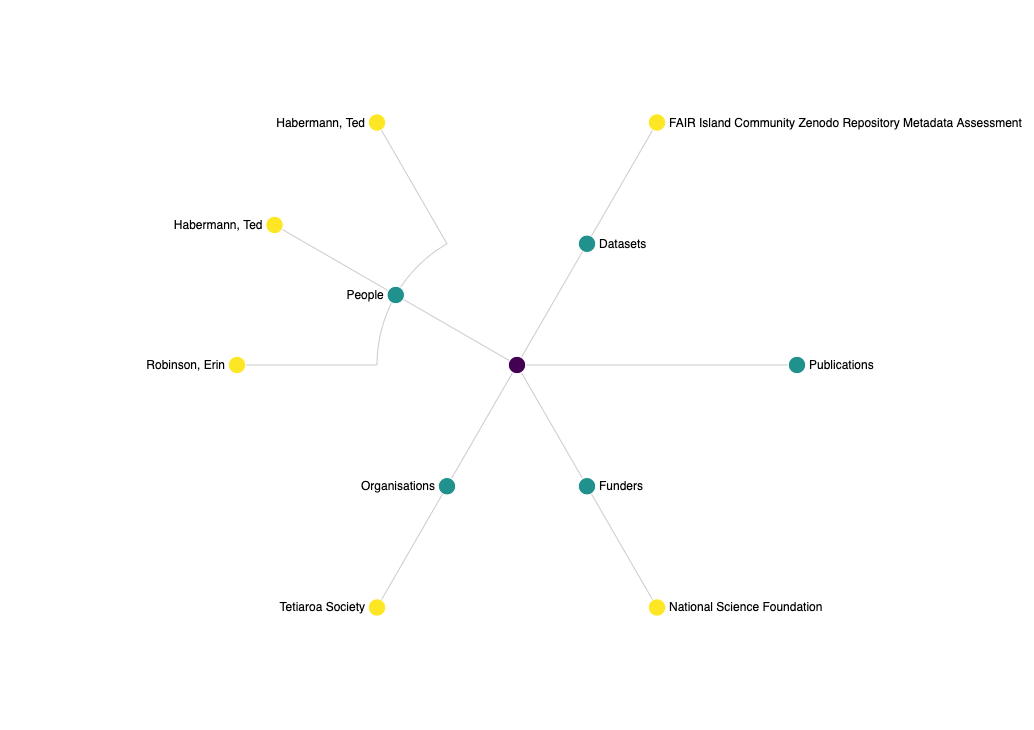


The process of displaying the DMP visulisation is very simple. First, and after a initial setup, we fetch all the we need from the DataCite GraphQL API. Then, we transform this data into a data structure that can be use for visulisation. Finally, we take the data tranformation and supply it to a Vega visulisation specification to generate the Chart you can see above. 




In [ ]:
%%capture
# Install required Python packages
!pip install dfply altair altair_saver vega altair_viewer gql requests_toolbelt altair_data_server

In [ ]:
import json
import pandas as pd
import numpy as np
from dfply import *
import altair.vega.v5 as alt
from altair_saver import save

alt.renderers.enable('colab')



PluginRegistry.enable('colab')

In [ ]:
# Prepare the GraphQL client
import requests
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

# Update with your DMPHub DOI here


In [ ]:
from IPython.display import display, Markdown
import ipywidgets as widgets
f = widgets.Dropdown(
    options=['https://doi.org/10.48321/D17P5X','https://doi.org/10.5281/zenodo.3245354','https://doi.org/10.48321/d1f88s','https://doi.org/10.48321/D17G67', 'https://doi.org/10.48321/D1H59R', 'https://doi.org/10.1575/1912/bco-dmo.775500.1', 'https://doi.org/10.48321/D1G59F','https://doi.org/10.48321/D14S38','https://doi.org/10.48321/D1101N','https://doi.org/10.48321/D1W88T','https://doi.org/10.48321/D1RG6W','https://doi.org/10.48321/D1MS3M','https://doi.org/10.48321/D1H010','https://doi.org/10.48321/D1C885','https://doi.org/10.48321/D17G67','https://doi.org/10.48321/D13S3Z','https://doi.org/10.48321/D1001B','https://doi.org/10.48321/D1V88H','https://doi.org/10.48321/D1QG6K','https://doi.org/10.48321/D1KS39','https://doi.org/10.48321/D1G01P'
],
    value='https://doi.org/10.48321/D17P5X',
    description='Choose DOI:',
    disabled=False,
)


In [ ]:
display(f)

Dropdown(description='Choose DOI:', options=('https://doi.org/10.48321/D17P5X', 'https://doi.org/10.5281/zenod…

## Fetching Data

We obtain all the data from the DataCite GraphQL API.


In [ ]:
# Generate the GraphQL query to retrieve up to 100 outputs of University of Oxford, with at least 100 views each.
query_params = {
    "id" : f.value,
    "maxOutputs": 100,
    "minViews" : 100
}

query = gql("""query getOutputs($id: ID!)
{
 dataManagementPlan(id: $id) {
    id
    name: titles(first:1) {
      title
    }
    datasets: citations(query:"types.resourceTypeGeneral:Dataset") {
        totalCount
        nodes {
          id: doi
          name: titles(first:1)  {
            title
          }
        }
      }
      publications: citations(query:"types.resourceTypeGeneral:Text") {
        totalCount
        nodes {
          id: doi
          name: titles(first:1)  {
            title
          }
        }
      }
    producer: contributors(contributorType: "Producer") {
      id
      name
      contributorType   
    }   
    fundingReferences {
      id: funderIdentifier
      name: funderName
      award: awardUri
    }
    creators {
      id
      name
      type
      affiliation{
        id
        name
      }
    } 
    pis: contributors(contributorType: "ProjectLeader") {
      id
      name
      contributorType
      affiliation{
        id
        name
      }
    }
    curators: contributors(contributorType: "DataCurator") {
      id
      name
      type
      affiliation{
        id
        name
      }
    }
  }
}
""")

In [ ]:
def get_data():
    return client.execute(query, variable_values=json.dumps(query_params))["dataManagementPlan"]


## Data Transformation

Simple transformations are performed to convert the graphql response into an array that can be take by Vega.

In [ ]:
def get_affiliation(series_element):
    if len(series_element) == 0:
        return "None"
    return series_element[0]['name']

In [ ]:
def add_node_attributes(dataframe, parent=2):
    """Modifies each item to include attributes needed for the node visulisation

    Parameters:
    dataframe (dataframe): A dataframe with all the itemss
    parent (int): The id of the parent node

    Returns:
    dataframe:Returning vthe same dataframe with new attributes

   """
    if (dataframe) is None:
        return pd.DataFrame() 
    else: 
        # print(dataframe) 
        return (dataframe >>
        mutate(
        id = X.id,
        tooltip = X.id,
        parent = parent,
        ))
  

In [ ]:
def create_node(array=[], parent=2):
    """creates a node for the chart and formats it

    Parameters:
    array (array): An array with all the itemss
    parent (int): The id of the parent node

    Returns:
    dict:Dict with all the nodes

   """
    # print(array)
    if len(array) == 0:
        return {} 
    else:
        # return {} if (array) is None else array
        df = add_node_attributes(pd.DataFrame(array,columns=array[0].keys()), parent)
        return df.to_dict(orient='records')
     

In [ ]:
def merge_nodes(dmpTitle,id,dataset=[],references=[],funders=[],orgs=[],people=[]):
    """Merges all the nodes lists

    Parameters:
    datasets (array): dataset nodes
    funders (array): funders nodes
    orgs (array): orgs nodes
    people (array): people nodes

    Returns:
    array:Array with all the nodes

   """
    dataset = [] if len(dataset) == 0 else dataset
    references = [] if len(references) == 0 else references
    funders = [] if len(funders) == 0 else funders
    orgs = [] if len(orgs) == 0 else orgs
    people = [] if len(people) == 0 else people

    dmp = {"id":id, "name": dmpTitle}
    datasets_node = {"id":2, "name": "Datasets", "parent":id}
    references_node = {"id":6, "name": "Publications", "parent":id}
    funders_node = {"id":3, "name": "Funders", "parent":id}
    organisations_node = {"id":4, "name": "Organisations", "parent":id}
    people_node = {"id":5, "name": "People", "parent":id}
    nodes_list = [dmp, datasets_node, references_node, funders_node,organisations_node,people_node] + dataset + references + funders + orgs + people,
    # return np.array(nodes_list, dtype=object)    
    return nodes_list[0]

In [ ]:
def get_title(series_element):
    if len(series_element) == 0:
        return "None"
    return series_element[0]['title']

In [ ]:
def extract_titles(list):
    if len(list) == 0:
        return []
    return (pd.DataFrame(list) >> 
        mutate(
             name = X.name.apply(get_title)
        )).to_dict('records')


In [ ]:
data = get_data()

datasets = create_node(extract_titles(data["datasets"]["nodes"]),2)
references = create_node(extract_titles(data["publications"]["nodes"]),6)
orgs = create_node(data["producer"],4)
people = create_node(data["creators"] + data["pis"] + data["curators"],5)
dmp_title = str('"' + data["name"][0]["title"] + '"')  
funders = create_node(data["fundingReferences"],3)
id = data["id"]
nodes = merge_nodes(" ",id, datasets, references, funders, orgs, people)

## Visulization

All transofrmed data is then feeded into a Vega specification for display.





In [ ]:
def vega_template(data):
    """Injects data into the vega specification

    Parameters:
    data (array): Array of nodes

    Returns:
    VegaSpec:Specification with data

   """
    return """
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of a radial layout for a node-link diagram of hierarchical data.",
  "width": 1024,
  "height": 720,
  "padding": 5,
  "autosize": "none",
  "signals": [
    {"name": "Chart", "value": """ +  dmp_title + """, "bind": {"input": "url", "size":100}},
    {"name": "labels", "value": true, "bind": {"input": "checkbox"}},
    {
      "name": "radius",
      "value": 280,
      "bind": {"input": "range", "min": 20, "max": 600}
    },
    {
      "name": "extent",
      "value": 360,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "rotate",
      "value": 0,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "layout",
      "value": "cluster",
      "bind": {"input": "radio", "options": ["tidy", "cluster"]}
    },
    {
      "name": "links",
      "value": "orthogonal",
      "bind": {
        "input": "select",
        "options": ["line", "curve", "diagonal", "orthogonal"]
      }
    },
    {"name": "originX", "update": "width / 2"},
    {"name": "originY", "update": "height / 2"}
  ],
  "data": [
    {
      "name": "tree",
      "values": """ + data + """,
      "transform": [
        {"type": "stratify", "key": "id", "parentKey": "parent"},
        {
          "type": "tree",
          "method": {"signal": "layout"},
          "size": [1, {"signal": "radius"}],
          "as": ["alpha", "radius", "depth", "children"]
        },
        {
          "type": "formula",
          "expr": "(rotate + extent * datum.alpha + 270) % 360",
          "as": "angle"
        },
        {"type": "formula", "expr": "PI * datum.angle / 180", "as": "radians"},
        {
          "type": "formula",
          "expr": "inrange(datum.angle, [90, 270])",
          "as": "leftside"
        },
        {
          "type": "formula",
          "expr": "originX + datum.radius * cos(datum.radians)",
          "as": "x"
        },
        {
          "type": "formula",
          "expr": "originY + datum.radius * sin(datum.radians)",
          "as": "y"
        }
      ]
    },
    {
      "name": "links",
      "source": "tree",
      "transform": [
        {"type": "treelinks"},
        {
          "type": "linkpath",
          "shape": {"signal": "links"},
          "orient": "radial",
          "sourceX": "source.radians",
          "sourceY": "source.radius",
          "targetX": "target.radians",
          "targetY": "target.radius"
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "color",
      "type": "linear",
      "range": {"scheme": "viridis"},
      "domain": {"data": "tree", "field": "depth"},
      "zero": true
    }
  ],
  "marks": [
    {
      "type": "path",
      "from": {"data": "links"},
      "encode": {
        "update": {
          "x": {"signal": "originX"},
          "y": {"signal": "originY"},
          "path": {"field": "path"},
          "stroke": {"value": "#ccc"}
        }
      }
    },
    {
      "type": "symbol",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "size": {"value": 300}, "stroke": {"value": "#fff"}
          },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "fill": {"scale": "color", "field": "depth"}
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "text": {"field": "name"},
          "fontSize": {"value": 12},
          "baseline": {"value": "middle"},
          "tooltip": {"signal": 
          "{'Identifier': datum.tooltip, 'Affiliation': datum.affiliation, 'Contribution': datum.contributorType, 'Award': datum.award}"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "dx": {"signal": "(datum.leftside ? -1 : 1) * 12"},
          "align": {"signal": "datum.leftside ? 'right' : 'left'"},
          "opacity": {"signal": "labels ? 1 : 0"}
        }
      }
    }
  ]
}

"""

In [ ]:
alt.vega(json.loads(vega_template(json.dumps(nodes))))



A series of sliders and option are included to interact with the visulisation is displayed. One can remove the labels, rotate the nodes, zoom in/out, and adjust the layout.